In [1]:
%matplotlib widget

import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord
import kepler as kpl
from scipy.integrate import odeint # this is new!
from mpl_toolkits.basemap import Basemap

In [2]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

day2sec = 86400.0

## Earth's parameters

In [3]:
a_ell = 6378137.0
c_ell = 6356752.314245
e_ell = np.sqrt(1 - c_ell ** 2  / a_ell ** 2)
mu = 3.986004418e14
R_mean = 6371008.0

## Satellite orbit parameters

In [4]:
altitude = 275000.0
a0 = R_mean + altitude
e0 = 0.01
i0 = 5  * deg2rad
w0 = 45  * deg2rad
W0 = 225.0 * deg2rad
M0 = 10.0 * deg2rad
t0 = 0.0
t1 = 86400.0 * 13.5
dt = 60
t  = np.arange(t0, t1, dt)

#### Drag parameters

In [5]:
C_d = 2.0 # drag coefficient
m   = 2.0 # mass 
A   = 1.0 # area
B   = C_d * A / m

#### Atmospheric density

In [6]:
def rho_atmospheric(r):
    h    = r - R_mean
    H0   = 7900.0
    rho0 = 1.2
    return rho0 * np.exp(- h / H0)

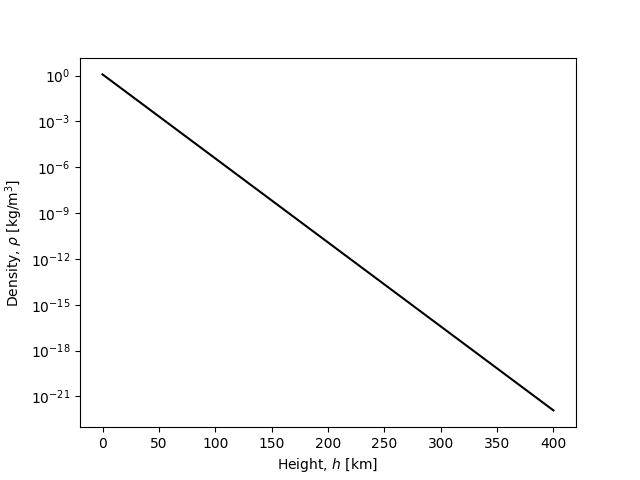

In [7]:
h_grid       = np.linspace(0, 400000.0,100)
r_grid       = R_mean + h_grid
rho_atm_grid = rho_atmospheric(r_grid)

plt.figure()
plt.plot(h_grid * 1e-3,rho_atm_grid,'-k')
plt.xlabel(r'Height, $h$ [km]')
plt.ylabel(r'Density, $\rho$ [kg/m$^3$]')
plt.yscale('log')

#### Conversion of anomalies

In [8]:
def E2nu(E, e):
    nu = np.sqrt((1 + e) / (1 - e)) 
    nu = 2 * np.arctan(nu * np.tan(E / 2))
    return nu

def nu2E(nu, e):
    cosnu = np.cos(nu)
    sinnu = np.sin(nu)
    sinE  = np.sqrt(1 - e * e) * sinnu / (1 + e * cosnu)
    cosE = (cosnu + e) / (1 + e * cosnu)
    E = v + np.arctan((sinE * cosnu - cosE * sinnu) / (cosE * cosnu + sinE * sinnu))

def E2M(E, e):
    return E - e * np.sin(E)

def M2E(M, e, E0):
    d   = np.array([1.0])
    eps = 1.0e-12
    E   = E0
    i   = 0
    while (d > eps).any():
        E_new = E - (E - e * np.sin(E) - M) / (1.0 - e * np.cos(E))
        d = np.abs(E_new - E)
        E = E_new
        i = i + 1
    return E, i

def nu2M(nu,e):
    E = nu2E(nu, e) # first, we compute the eccentric anomaly
    return E2M(E, e)

def M2nu(M,e):
    E, _ = M2E(M, e, M) # first, we compute the eccentric anomaly
    return E2nu(E, e)

## Numerical integration example

In [9]:
(x0, y0, z0, vx0, vy0, vz0) = kpl.elem2coord(a0, e0, i0, w0, W0, M0, t0, t0, mu)

#### Define a function that returns the derivative of the state vector

In [10]:
# function that returns dy/dt
def two_body_with_drag(y,t):
    r_vec = y[:3]
    v_vec = y[3:]

    # Create the derivative vector and copy the velocities into it
    y_dot = np.zeros_like(y)
    y_dot[:3] = y[3:]

    # Calculate the accelerations
    x = r_vec[0]
    y = r_vec[1]
    z = r_vec[2]

    vx = v_vec[0]
    vy = v_vec[1]
    vz = v_vec[2]
    
    r_mag         = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    v2            = vx ** 2 + vy ** 2 + vz ** 2 # velocity squared
    v_mag         = np.sqrt(v2)

    a_central_vec = - mu * r_vec / (r_mag ** 3)
    y_dot[3:]     = a_central_vec

    # Compute acceleration due to drag
    rho = rho_atmospheric(r_mag)
    coef = - 0.5 * B * rho * v2

    ax_drag = coef * vx / v_mag
    ay_drag = coef * vy / v_mag
    az_drag = coef * vz / v_mag

    y_dot[3] = y_dot[3] + ax_drag
    y_dot[4] = y_dot[4] + ay_drag
    y_dot[5] = y_dot[5] + az_drag
    
    return y_dot

#### Create initial conditions 

In [11]:
# initial condition
state_initial = np.array([x0, y0, z0, vx0, vy0, vz0])
print(state_initial)

[ 1.15094537e+06 -6.46200600e+06  4.70966308e+05  7.68777027e+03
  1.38372085e+03  3.89992624e+02]


#### Integrate using ODEINT function from the scipy numerical package

In [12]:
# absolute tolerance
atol = 1e-12

# relative tolerance
rtol = 1e-12

# solve ODE
state = odeint(two_body_with_drag, state_initial, t, rtol = rtol, atol = atol)

# extract position and velocity
r_eci_num = state[:,:3]
v_eci_num = state[:,3:]

x = state[:,0]
y = state[:,1]
z = state[:,2]

vx = state[:,3]
vy = state[:,4]
vz = state[:,5]

#### Compute osculating orbital elements

In [13]:
(a, e, i, w, W, M) = kpl.coord2elem(x, y, z, vx, vy, vz, mu)
print(a)

[6646008.         6645997.15058174 6645987.76671155 ... 6575997.33354923
 6575990.71930536 6575984.09951018]


## Plot orbital elements

In [14]:
#### Semimajor axis

Text(0, 0.5, 'a, q, Q [km]')

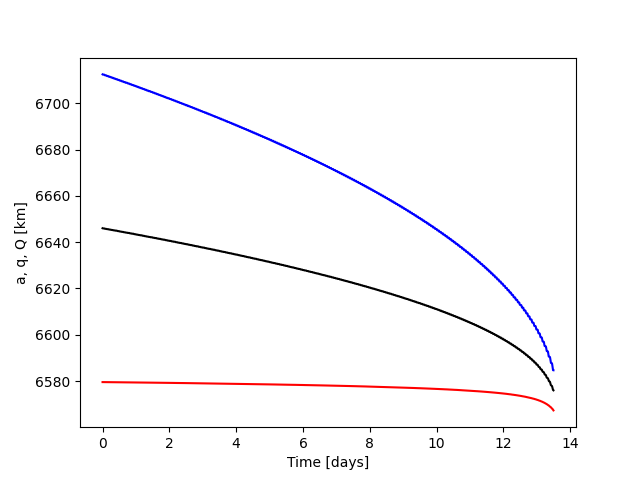

In [24]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, a * 1e-3,'-k')


plt.plot(t / day2sec, a * (1-e) * 1e-3,'-r')
plt.plot(t / day2sec, a * (1+e) * 1e-3,'-b')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('a, q, Q [km]')

In [16]:
#### Eccentricity

Text(0, 0.5, 'Eccentricity []')

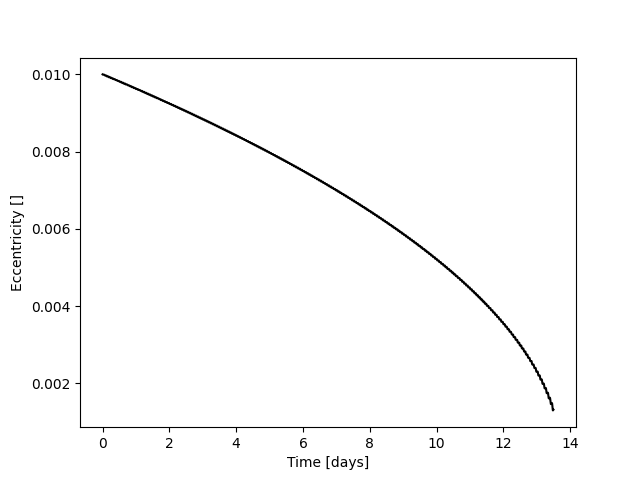

In [17]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, e ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Eccentricity []')

#### Inclination

Text(0, 0.5, 'Inclination [deg]')

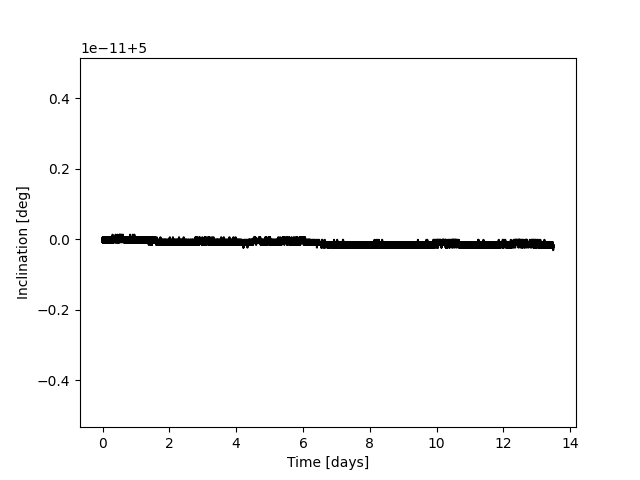

In [18]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, i * rad2deg ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Inclination [deg]')

#### Argument of pericenter

Text(0, 0.5, 'Argument of pericenter [deg]')

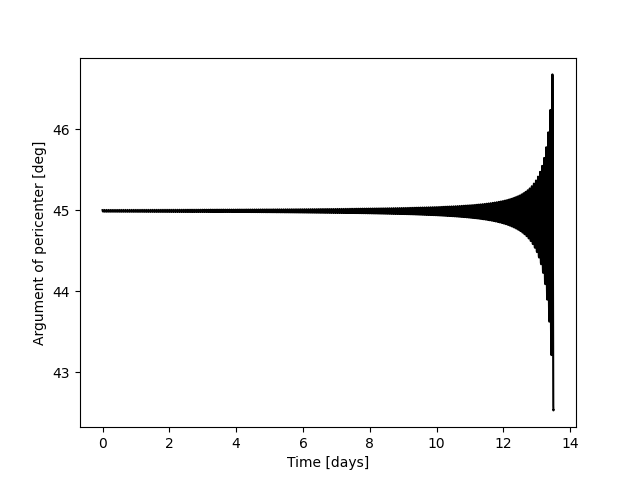

In [19]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, w * rad2deg ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Argument of pericenter [deg]')

#### Longitude of the ascending node

Text(0, 0.5, 'Longitude of the ascending node [deg]')

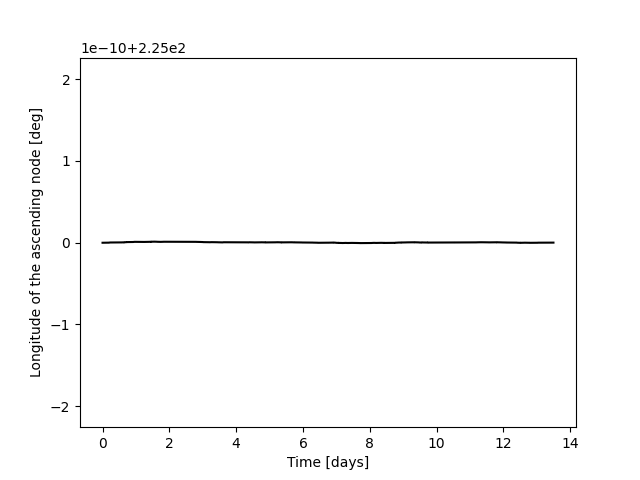

In [20]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, W * rad2deg ,'-k')
# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Longitude of the ascending node [deg]')

In [21]:
n_unperturbed = np.sqrt(mu / a0 ** 3)
M_unperturbed = np.mod(M0 + n_unperturbed * (t - t0), 2*pi)

# Compute difference in mean anomaly
M_diff = (M - M_unperturbed)
filt1 = M_diff > pi
M_diff[filt1] = M_diff[filt1] - 2 * pi

filt2 = M_diff < - pi
M_diff[filt2] = M_diff[filt2] + 2 * pi

Text(0.5, 0, 'Time [days]')

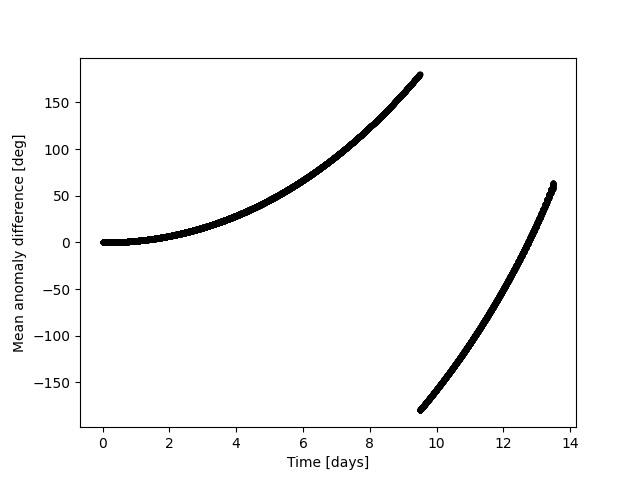

In [22]:
ax = plt.figure()
# Plot orbit
plt.plot( t / day2sec, M_diff * rad2deg , '.k')

# setting title and labels 
plt.ylabel('Mean anomaly difference [deg]')
plt.xlabel('Time [days]')